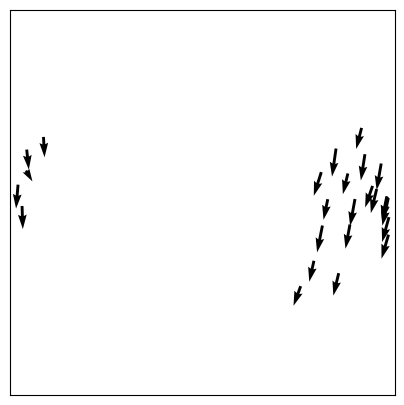

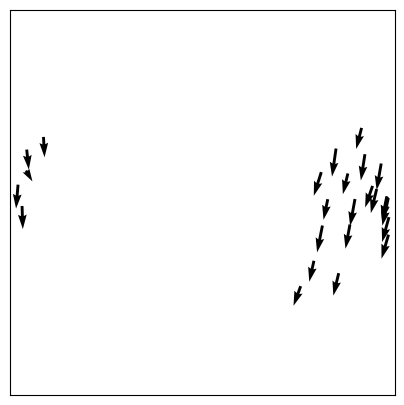

In [24]:
# =============================================================================
# Importing Packages
# =============================================================================  

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

# =============================================================================
# Parameters
# =============================================================================

# -----------------------------------------------------------------------------
# Birds
# -----------------------------------------------------------------------------

N = 25                   # Number of birds

bird_speed = 1.0         # Ideal constant speed of birds 
bird_speed_max = 1.0     # Maximum speed of birds 

R_bird = 2.0             # Bird-Bird neighbour view radius
R_min =  0.7             # Bird-Bird minimum distance to maintain


# Migration vector goal
goal_angle = np.random.uniform(0, 2 * np.pi)  # Random angle in [0, 2π)
goal_x = np.cos(goal_angle) 
goal_y = np.sin(goal_angle)

# -----------------------------------------------------------------------------
# 'Mixing' parameters
# -----------------------------------------------------------------------------

# These are weights for the different contributions to the bird's velocity

lam_c = .1              # Centering weight
lam_a = .15              # Avoidance weight
lam_m = .1              # Matching weight
lam_o = .0              # Obstacle weight
lam_g = .05             # Migratory weight

# -----------------------------------------------------------------------------
# Time & Space
# -----------------------------------------------------------------------------

L = 10                   # Size of box (Area of a wind farm)

dt = 0.1                 # Time step
Nt = 200                 # No. of time steps

# =============================================================================
# Bird Functions
# =============================================================================

# This section contains functions for bird behaviour. Specifically:
# flock_random() - Initialises a random 

# -----------------------------------------------------------------------------
# Initialise Birds
# -----------------------------------------------------------------------------

def normalise(v):
    """ normalise a vector to length 1  """
    norm = np.linalg.norm(v)
    
    if norm == 0:
        return v
    
    return v / norm

def flock_random(N, L, bird_speed):
    '''
    Set initial positions, direction, and velocities 
    '''
    # Bird positions are randomly distributed within the square area of side L
    x = np.random.rand(N, 1)*L
    y = np.random.rand(N, 1)*L

    # Bird directions are uniformly distributed across a full 360 degree range
    theta = 2 * np.pi * np.random.rand(N, 1)
    
    # Bird start with the same speed but acorss uniform range of directions 
    vx = bird_speed * np.cos(theta)
    vy = bird_speed * np.sin(theta)

    return x, y, vx, vy

def flock_uniform(N, L, bird_speed):
    '''
    Set initial positions as a uniform placement starting at the edge of the box.
    Set direction and velocity to be uniform with a small amount of noise 
    '''

    # Set bird initial flock as a square
    N_per_side = int(np.sqrt(N))
    
    # Midpoint of area 
    midpoint = L//2
    
    # Define the x locations (start in centre of perimeter)
    half_length = N_per_side // 2
    start = midpoint - half_length
    x_locs = np.arange(start, start + N_per_side)
    
    # Define the y locations (start from bottom)
    y_locs = np.arange(0, N_per_side)
    
    # Define bird starting points
    # Initialise lists
    x = []
    y = []
    
    for x_loc in x_locs:
        for y_loc in y_locs:
            x.append([x_loc])
            y.append([y_loc])
    
    # Turn into numpy arrays
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    
    # Bird Angle
    # Make all birds same starting angle
    theta = 2 * np.pi * np.random.rand(N, 1)

    # Bird velocities
    vx = bird_speed * np.cos(theta)
    vy = bird_speed * np.sin(theta)
  
    return x, y, vx, vy

# -----------------------------------------------------------------------------
# Find Neighbours
# -----------------------------------------------------------------------------

def proximity_lists(i, x, y, R_bird, R_min):
    """
    The function finds the neighbouring and too close birds for a specific bird
    """

    # Compute distances from bird "i" to all other birds
    distances = np.sqrt((x - x[i])**2 + (y - y[i])**2)
    
    # Define the set of neighbours that the bird can see
    neighbours = np.where(distances <= R_bird)[0]
        
    # Define the set of birds that are too close
    too_close = np.where(distances <= R_min)[0]

    # Excluding the bird itself
    neighbours = neighbours[neighbours != i]
    too_close = too_close[too_close != i]   
    
    return neighbours, too_close    

# -----------------------------------------------------------------------------
# Centre Velocity - Move towards the centre of the flock
# -----------------------------------------------------------------------------
  
def centre_vel(i, x, y, neighbours):
    
    # If there are no neighbors, no center-of-mass contribution
    if len(neighbours) == 0:
        return 0, 0

    # Compute center of mass of neighbors
    com_x = np.mean(x[neighbours])
    com_y = np.mean(y[neighbours])

    # Compute the vector pointing towards the center of mass
    direction_to_com = np.array([com_x - x[i][0], com_y - y[i][0]])

    # Normalize the vector
    normalized_direction = normalise(direction_to_com)

    # Extract the components
    centre_vx, centre_vy = normalized_direction

    return centre_vx, centre_vy
    
# -----------------------------------------------------------------------------
# Avoidance Velocity - avoid colissions with to align with other birds
# -----------------------------------------------------------------------------
    
def avoid_vel(i, x, y, too_close):
    
    # If there are no birds too close, no avoidance needed
    if len(too_close) == 0:
        return 0, 0

    # Initialize avoidance velocity components
    avoid_vx = 0
    avoid_vy = 0

    # Compute avoidance velocity contributions
    avoid_vx = (x[i][0] - x[too_close][0])
    avoid_vy = (y[i][0] - y[too_close][0])
    
    # Normalize the avoidance vector to ensure a unit direction
    normalised_avoidance = normalise(np.array([avoid_vx, avoid_vy]))

    # Extract the components
    avoid_vx, avoid_vy = normalised_avoidance

    return avoid_vx, avoid_vy

# -----------------------------------------------------------------------------
# Matching Velocity - match velocity to align with neighbours
# -----------------------------------------------------------------------------
    
def match_vel(i, vx, vy, neighbours):
    
    # Check if there are no neighbors
    if len(neighbours) == 0:
        return 0, 0

    # Calculate average neighbor velocity
    avg_vx = np.mean(vx[neighbours])
    avg_vy = np.mean(vy[neighbours])

    # Compute the velocity difference vector
    velocity_difference = np.array([avg_vx - vx[i][0], avg_vy - vy[i][0]])

    # Normalize the velocity difference to ensure a unit vector
    normalized_match = normalise(velocity_difference)

    # Extract the components
    match_vx, match_vy = normalized_match

    return match_vx, match_vy

# -----------------------------------------------------------------------------
# Migration Velocity - a common goal velocity for the flock
# -----------------------------------------------------------------------------

def migratory_vel(goal_x, goal_y):
    
    normalized_goal = normalise(np.array([goal_x, goal_y]))
    
    migrate_vx, migrate_vy = normalized_goal
    
    return migrate_vx, migrate_vy

# -----------------------------------------------------------------------------
# Update velocities
# -----------------------------------------------------------------------------
       
def update_velocity(i, vx, vy, \
                    obstacle_vx, obstacle_vy, \
                    centre_vx, centre_vy, \
                    avoid_vx, avoid_vy, \
                    match_vx, match_vy, \
                    migrate_vx, migrate_vy, \
                    bird_speed_max, \
                    lam_a, \
                    lam_c, \
                    lam_m, \
                    lam_o, \
                    lam_g):
    
    
    # Update velocities with contributions
    vx_new = vx[i][0] + \
             lam_o * obstacle_vx + \
             lam_c * centre_vx + \
             lam_a * avoid_vx + \
             lam_m * match_vx + \
             lam_g * migrate_vx
             
    vy_new = vy[i][0] + \
             lam_o * obstacle_vy + \
             lam_c * centre_vy + \
             lam_a * avoid_vy + \
             lam_m * match_vy + \
             lam_g * migrate_vy

    
    # Compute the current speed
    current_speed = np.linalg.norm([vx[i][0], vy[i][0]])
    
    # Add small noise to the direction
    # noise_factor = 0.01 * current_speed  
    # vx_new += np.random.uniform(-noise_factor, noise_factor)
    # vy_new += np.random.uniform(-noise_factor, noise_factor)
    
    vx_new = min(1, bird_speed_max/current_speed) * vx_new
    vy_new = min(1, bird_speed_max/current_speed) * vy_new
        
    return vx_new, vy_new

# =============================================================================
# Update Steps
# ============================================================================= 

def step(x, y, vx, vy, L, R_bird, R_min, N, dt, bird_speed_max, lam_a, lam_c, lam_m, lam_o, lam_g, goal_x, goal_y):
    '''
    
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    
    '''
    
    # Update positions based on velocity and time step
    x += vx * dt
    y += vy * dt
    
    # Apply periodic boundary conditions
    x %= L
    y %= L
    
    # Initialise the new velocities
    vx_new = np.zeros(N)
    vy_new = np.zeros(N)
    
    # For each bird:
    for i in range(N):
        
        # Find neighbouring birds and those that are too close
        neighbours, too_close = proximity_lists(i, x, y, R_bird, R_min)
        
        # Obstacle avoidance component
        obstacle_vx, obstacle_vy = 0, 0
        
        # Center of mass component
        centre_vx, centre_vy = centre_vel(i, x, y, neighbours)
        
        # Bird avoidance component
        avoid_vx, avoid_vy = avoid_vel(i, x, y, too_close)
        
        # Matching component
        match_vx, match_vy = match_vel(i, vx, vy, neighbours)
        
        # Migrating component
        migrate_vx, migrate_vy = migratory_vel(goal_x, goal_y)
           
        # Update velocity with limits
        vx_new[i], vy_new[i] = update_velocity(i, vx, vy, \
                                obstacle_vx, obstacle_vy, \
                                centre_vx, centre_vy, \
                                avoid_vx, avoid_vy, \
                                match_vx, match_vy, \
                                migrate_vx, migrate_vy, \
                                bird_speed_max, \
                                lam_a, \
                                lam_c, \
                                lam_m, \
                                lam_o, \
                                lam_g)
    

    # Update new velocities
    vx = np.array(vx_new).reshape(-1, 1)
    vy = np.array(vy_new).reshape(-1, 1)
    
    return x, y, vx, vy

def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    
    return q

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 5))

# Get the initial configuration
# x, y, vx, vy = flock_random(N, L, bird_speed)
x, y, vx, vy = flock_uniform(N, L, bird_speed)

# Initialize quiver plot
q = ax.quiver(x, y, vx, vy)

# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


# Function to update each frame
for t in range(Nt):
    x, y, vx, vy = step(x, y, vx, vy, L, R_bird, R_min, N, dt, bird_speed_max, lam_a, lam_c, lam_m, lam_o, lam_g, goal_x, goal_y)
    q = update_quiver(q, x, y, vx, vy)
    clear_output(wait=True)
    display(fig)